In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import seaborn as sns
plt.rcParams['figure.dpi'] = 300
import matplotlib.dates as mdates
import missingno as msno
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plot
import seaborn as sns

from datetime import datetime, date 


C:\Users\Safeer\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
aq_auser =  pd.read_csv('Aquifer_Auser.csv', index_col = 'Date')
aq_doganella =  pd.read_csv('Aquifer_Doganella.csv', index_col = 'Date')
aq_luco = pd.read_csv('Aquifer_Luco.csv', index_col = 'Date')
aq_petrignano = pd.read_csv('Aquifer_Petrignano.csv', index_col = 'Date')
lk_bilancino = pd.read_csv('Lake_Bilancino.csv', index_col = 'Date')
rv_arno = pd.read_csv('River_Arno.csv', index_col = 'Date')
ws_amiata =  pd.read_csv('Water_Spring_Amiata.csv', index_col = 'Date')
ws_lupa =  pd.read_csv('Water_Spring_Lupa.csv', index_col = 'Date')
ws_madonna = pd.read_csv('Water_Spring_Madonna_di_Canneto.csv', index_col = 'Date')

In [3]:
#aq_auser.isna().sum()  
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in 'C:\\Users\\Safeer\\My Drive\\Git_Project\\Water_prediction\\Acea-Water-Prediction\\acea-water-prediction-data': ['.ipynb_checkpoints', 'Aquifer_Auser.csv', 'Aquifer_Auser_C.csv', 'Aquifer_Doganella.csv', 'Aquifer_Doganella_C.csv', 'Aquifer_Luco.csv', 'Aquifer_Petrignano.csv', 'datasets_description.ods', 'datasets_description.xlsx', 'Lake_Bilancino.csv', 'Project_forcasting.ipynb', 'River_Arno.csv', 'Water_Spring_Amiata.csv', 'Water_Spring_Lupa.csv', 'Water_Spring_Madonna_di_Canneto.csv']


In [4]:

files = []
for dirname, _, filenames in os.walk(r'C:\Users\Madina\Untitled Folder 16\files'):
    for filename in filenames:
#        print(os.path.join(dirname, filename))
        if '.csv' in filename:
            files +=list([filename])



# Creating a brief dataframe to compare the qty of rows and cols of each file.

datasets_df = pd.DataFrame(columns=['File_Name'], data=files)
datasets_df['Waterbody_type'] = datasets_df.File_Name.apply(lambda x: x.split('_')[0])
datasets_df['Qty_Rows'] = datasets_df.File_Name.apply(lambda x: pd.read_csv(f'Aquifer_Auser.csv').shape[0])
datasets_df['Qty_Cols'] = datasets_df.File_Name.apply(lambda x: pd.read_csv(f'Aquifer_Auser.csv').shape[1])
datasets_df = datasets_df.replace('Water','Water_Spring')
datasets_df = datasets_df.sort_values(by=['Waterbody_type','Qty_Rows'], ascending=[True,False]).reset_index(drop=True)
#datasets_df.style.bar(subset=['Qty_Rows','Qty_Cols'], color='#118DFF')
datasets_df
datasets=[aq_auser,aq_doganella,aq_luco,aq_petrignano,lk_bilancino,rv_arno,ws_amiata,ws_lupa,ws_madonna]


<AxesSubplot:xlabel='Features'>

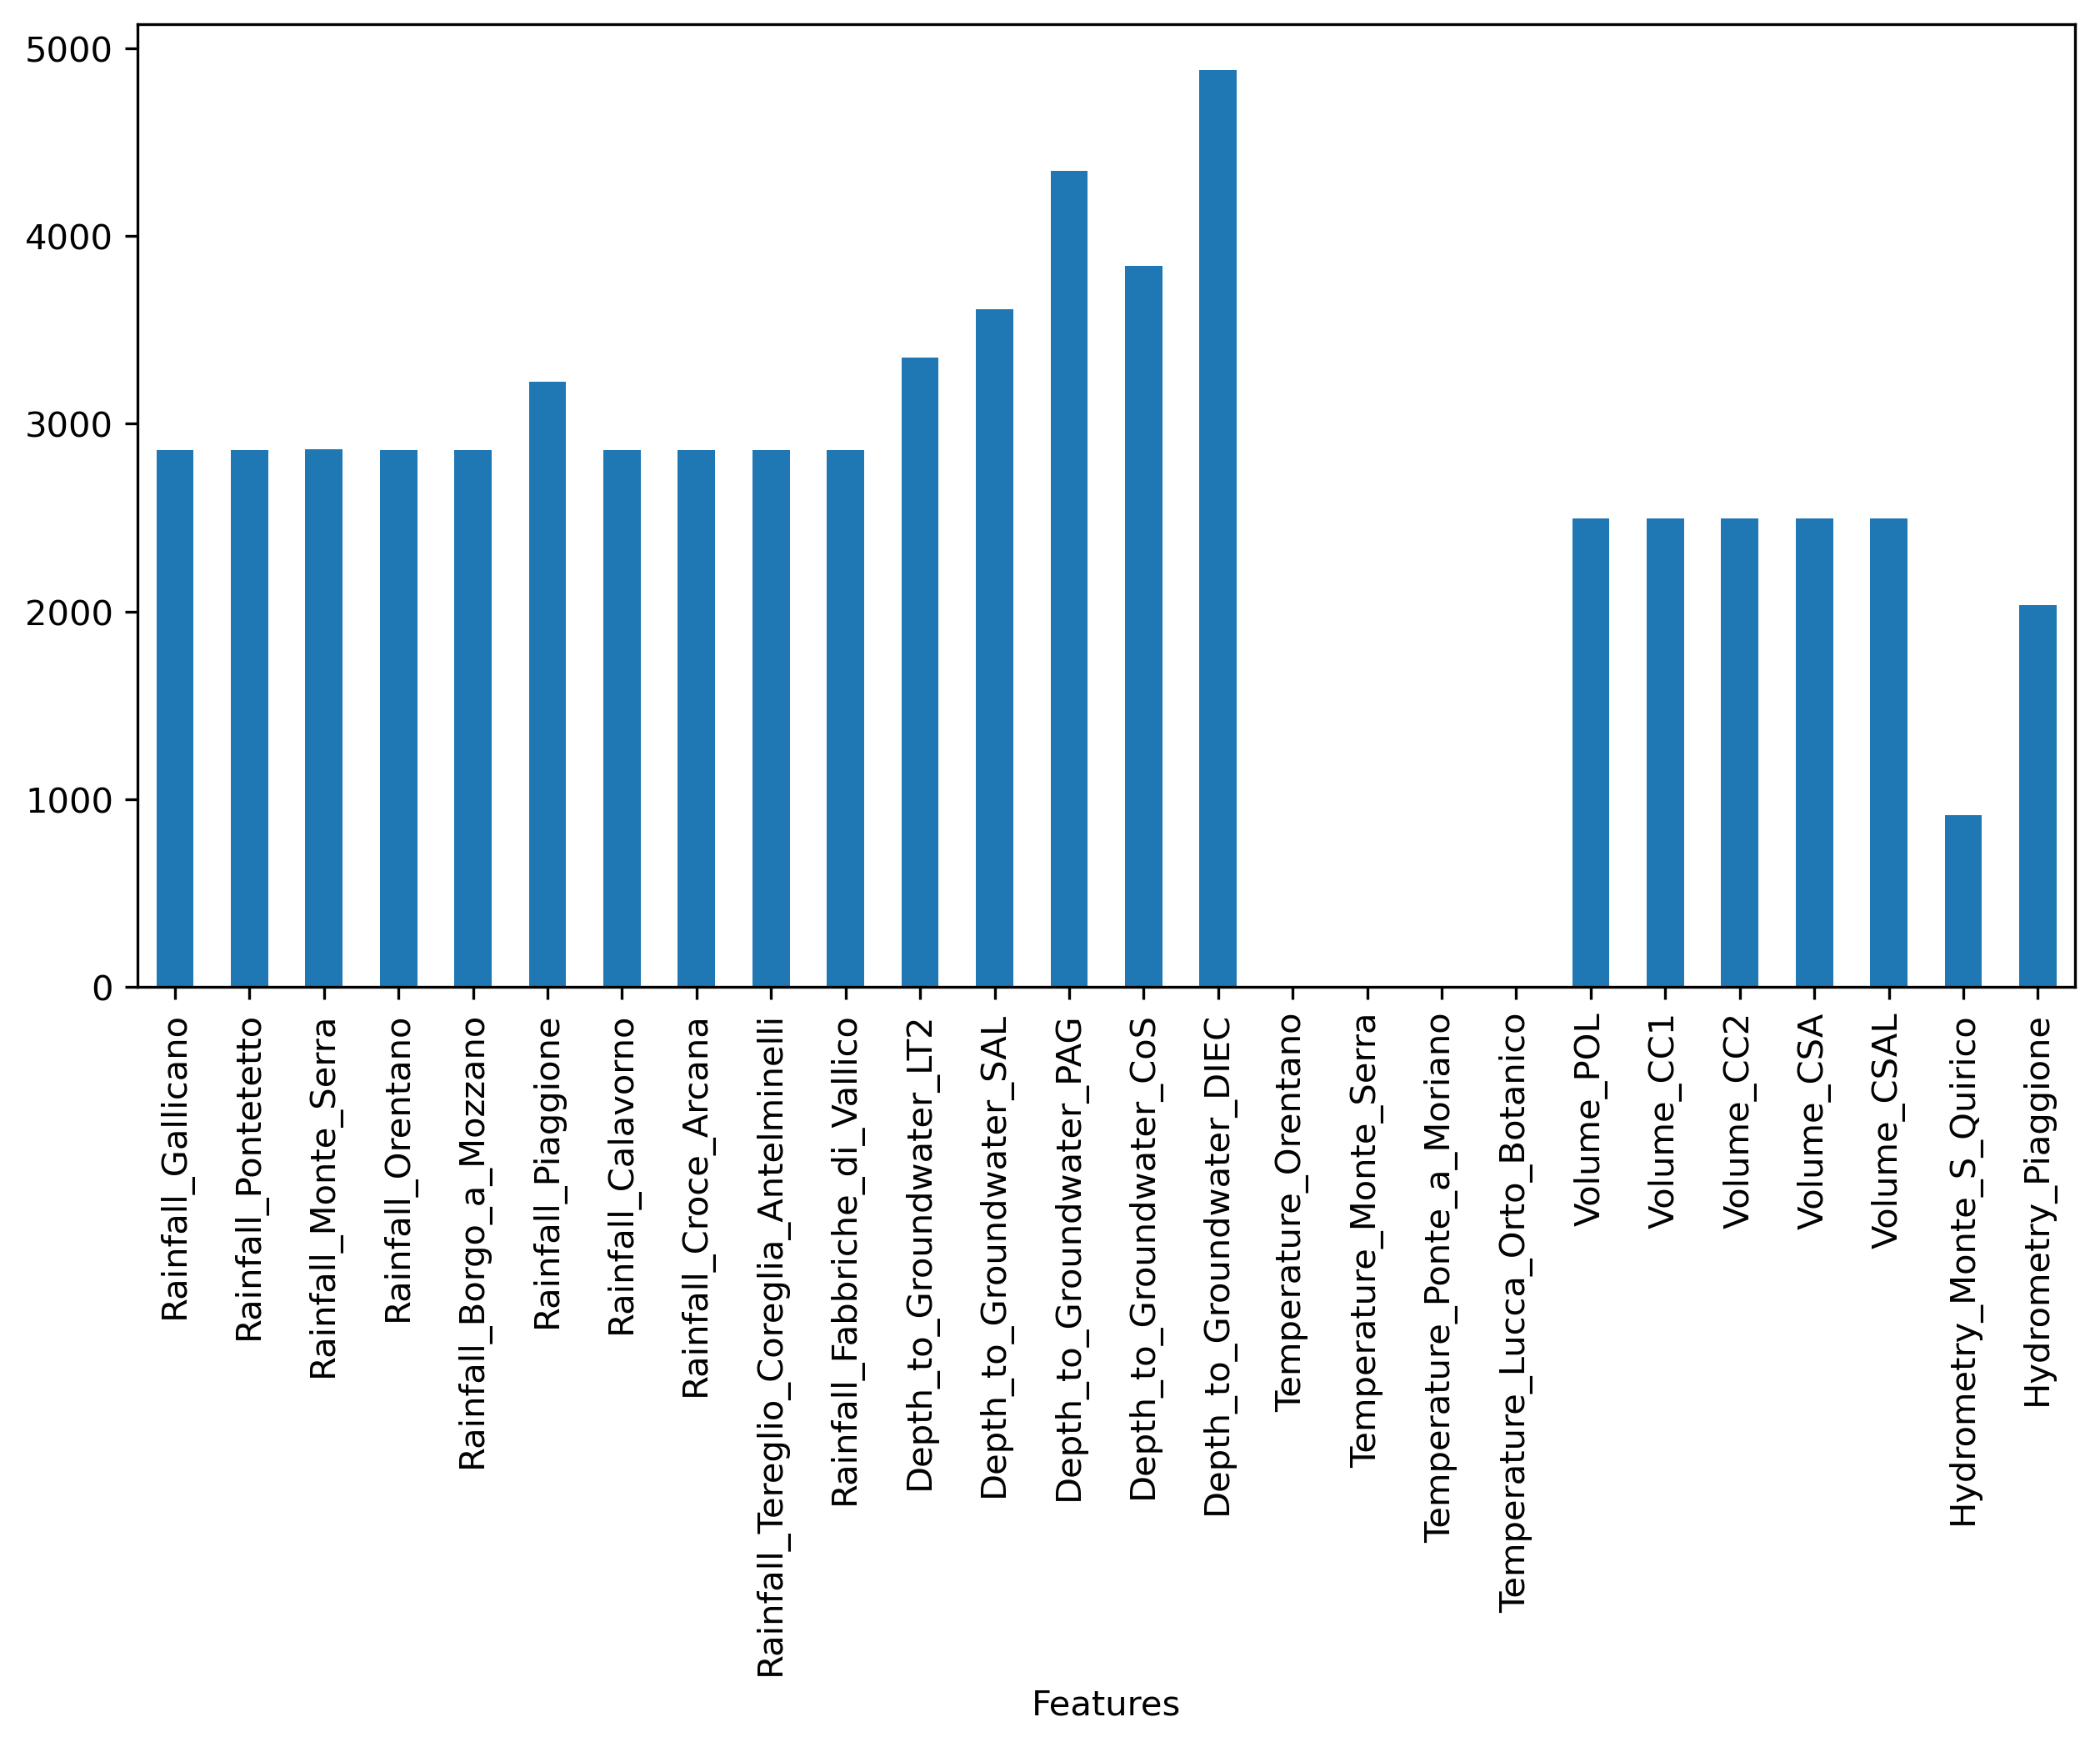

In [5]:
auser_null = aq_auser.isnull().sum()
auser_null.values
fig  = plot.figure ()
auser_null.plot(kind = 'bar', figsize = (10,5), xlabel = "Features", xlim = {0,100})
#plot.bar(x = auser_null.values, height = auser_null.item) 



In [6]:
#Stating each waterbody target
auser_targets = ['Depth_to_Groundwater_LT2', 'Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS']
doganella_targets = ['Depth_to_Groundwater_Pozzo_1','Depth_to_Groundwater_Pozzo_2','Depth_to_Groundwater_Pozzo_3',
                     'Depth_to_Groundwater_Pozzo_4','Depth_to_Groundwater_Pozzo_5','Depth_to_Groundwater_Pozzo_6',
                     'Depth_to_Groundwater_Pozzo_7','Depth_to_Groundwater_Pozzo_8','Depth_to_Groundwater_Pozzo_9']
luco_targets = ['Depth_to_Groundwater_Podere_Casetta']
petrignano_targets = ['Depth_to_Groundwater_P24', 'Depth_to_Groundwater_P25']
bilancino_targets = ['Lake_Level', 'Flow_Rate']
arno_targets = ['Hydrometry_Nave_di_Rosano']
amiata_targets = ['Flow_Rate_Bugnano','Flow_Rate_Arbure', 
                  'Flow_Rate_Ermicciolo','Flow_Rate_Galleria_Alta']
lupa_targets = ['Flow_Rate_Lupa']
madonna_targets = ['Flow_Rate_Madonna_di_Canneto']

In [36]:
#Defining some functions
def df_relinfo(df, target_var=[]):
    x = pd.DataFrame(df.isna().sum().apply(lambda x: x/df.shape[0])).reset_index().rename(columns={'index':'Feature',0:'%Na'})
    x['Na_qty'] = df.isna().sum().tolist()
    x['Variable'] = x.Feature.apply(lambda x: 'Target' if x in target_var else 'Predictor')
    return x.sort_values(by='%Na', ascending = False).reset_index(drop=True).style.bar(subset = ['%Na'], color = '#118DFF')

def corr_plot(data, top_visible=False, right_visible=False, bottom_visible=True, left_visible=False, ylabel=None, figsize=(15,11), axis_grid='y'):
    fig, ax = plt.subplots(figsize=figsize)
    plt.title('Correlations (Pearson)', size=15, fontweight='bold')
    mask = np.triu(np.ones_like(data.corr(), dtype=bool))
    sns.heatmap(round(data.corr(), 2), mask=mask, cmap='viridis', annot=True)
    plt.show()
    
def line_plot(data, y, title, color, top_visible=False, right_visible=False, bottom_visible=True, left_visible=False,
             ylabel=None, figsize=(10,4), axis_grid='y'):
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title, size=15, fontweight='bold')
    
    for i in ['top','right','bottom','left']:
        ax.spines[i].set_color('black')
    #    ax.spines[i].set_visible(i+'_visible')
    
    ax.spines['top'].set_visible(top_visible)
    ax.spines['right'].set_visible(right_visible)
    ax.spines['bottom'].set_visible(bottom_visible)
    ax.spines['left'].set_visible(left_visible)
    
    sns.lineplot(x=range(len(data[y])), y=data[y], dashes=False, color=color, linewidth=.5)
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    
    ax.set_xticks([])
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.ylabel(ylabel)
    ax.grid(axis=axis_grid, alpha=0.9, linestyle='--')
    plt.show()

def columns_viz(data, color):
    for i in range(len(data.columns)):
        line_plot(data=data, y=data.columns[i], color=color, 
                 title='{} dynamics'.format(data.columns[i]),
                  bottom_visible=False, figsize=(10,2))
        
# some more helper functions
def add_month(df):
    """
    Convert date to a date object, then create the month column
    """
    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by = 'Date')
    
    df['Month'] = pd.DatetimeIndex(df['Date']).month
    return df

def add_year(df):
    """
    add a column for the year
    """
    df['Year'] = pd.DatetimeIndex(df['Date']).year
    return df

def add_seasons(df):
    """
    This function will add the season (winter, spring, summer, autumn) based on the month
    Spring: March, April, May
    Summer: June, July, August
    Autumn: September, October, November
    Winter: December, January, February
    """
    months = df['Month'].unique()
    df['Season'] = df['Month']
    for month in months:
        if month in [12,1,2]:
            df.loc[lambda df: df['Month'] == month, 'Season'] = '1_Winter'
        elif month in [3,4,5]:
            df.loc[lambda df: df['Month'] == month, 'Season'] = '2_Spring'
        elif month in [6,7,8]:
            df.loc[lambda df: df['Month'] == month, 'Season'] = '3_Summer'
        else:
            df.loc[lambda df: df['Month'] == month, 'Season'] = '4_Autumn'
    return df

def do_dates(df):
    df = add_month(df)
    df = add_year(df)
    df = add_seasons(df)
    return df

In [8]:
print('The earliest date is: \t', datasets[5].index[0])
print('The latest date is: \t', datasets[5].index[-1])

The earliest date is: 	 01/01/1998
The latest date is: 	 30/06/2020


In [9]:
df_relinfo(rv_arno,arno_targets)

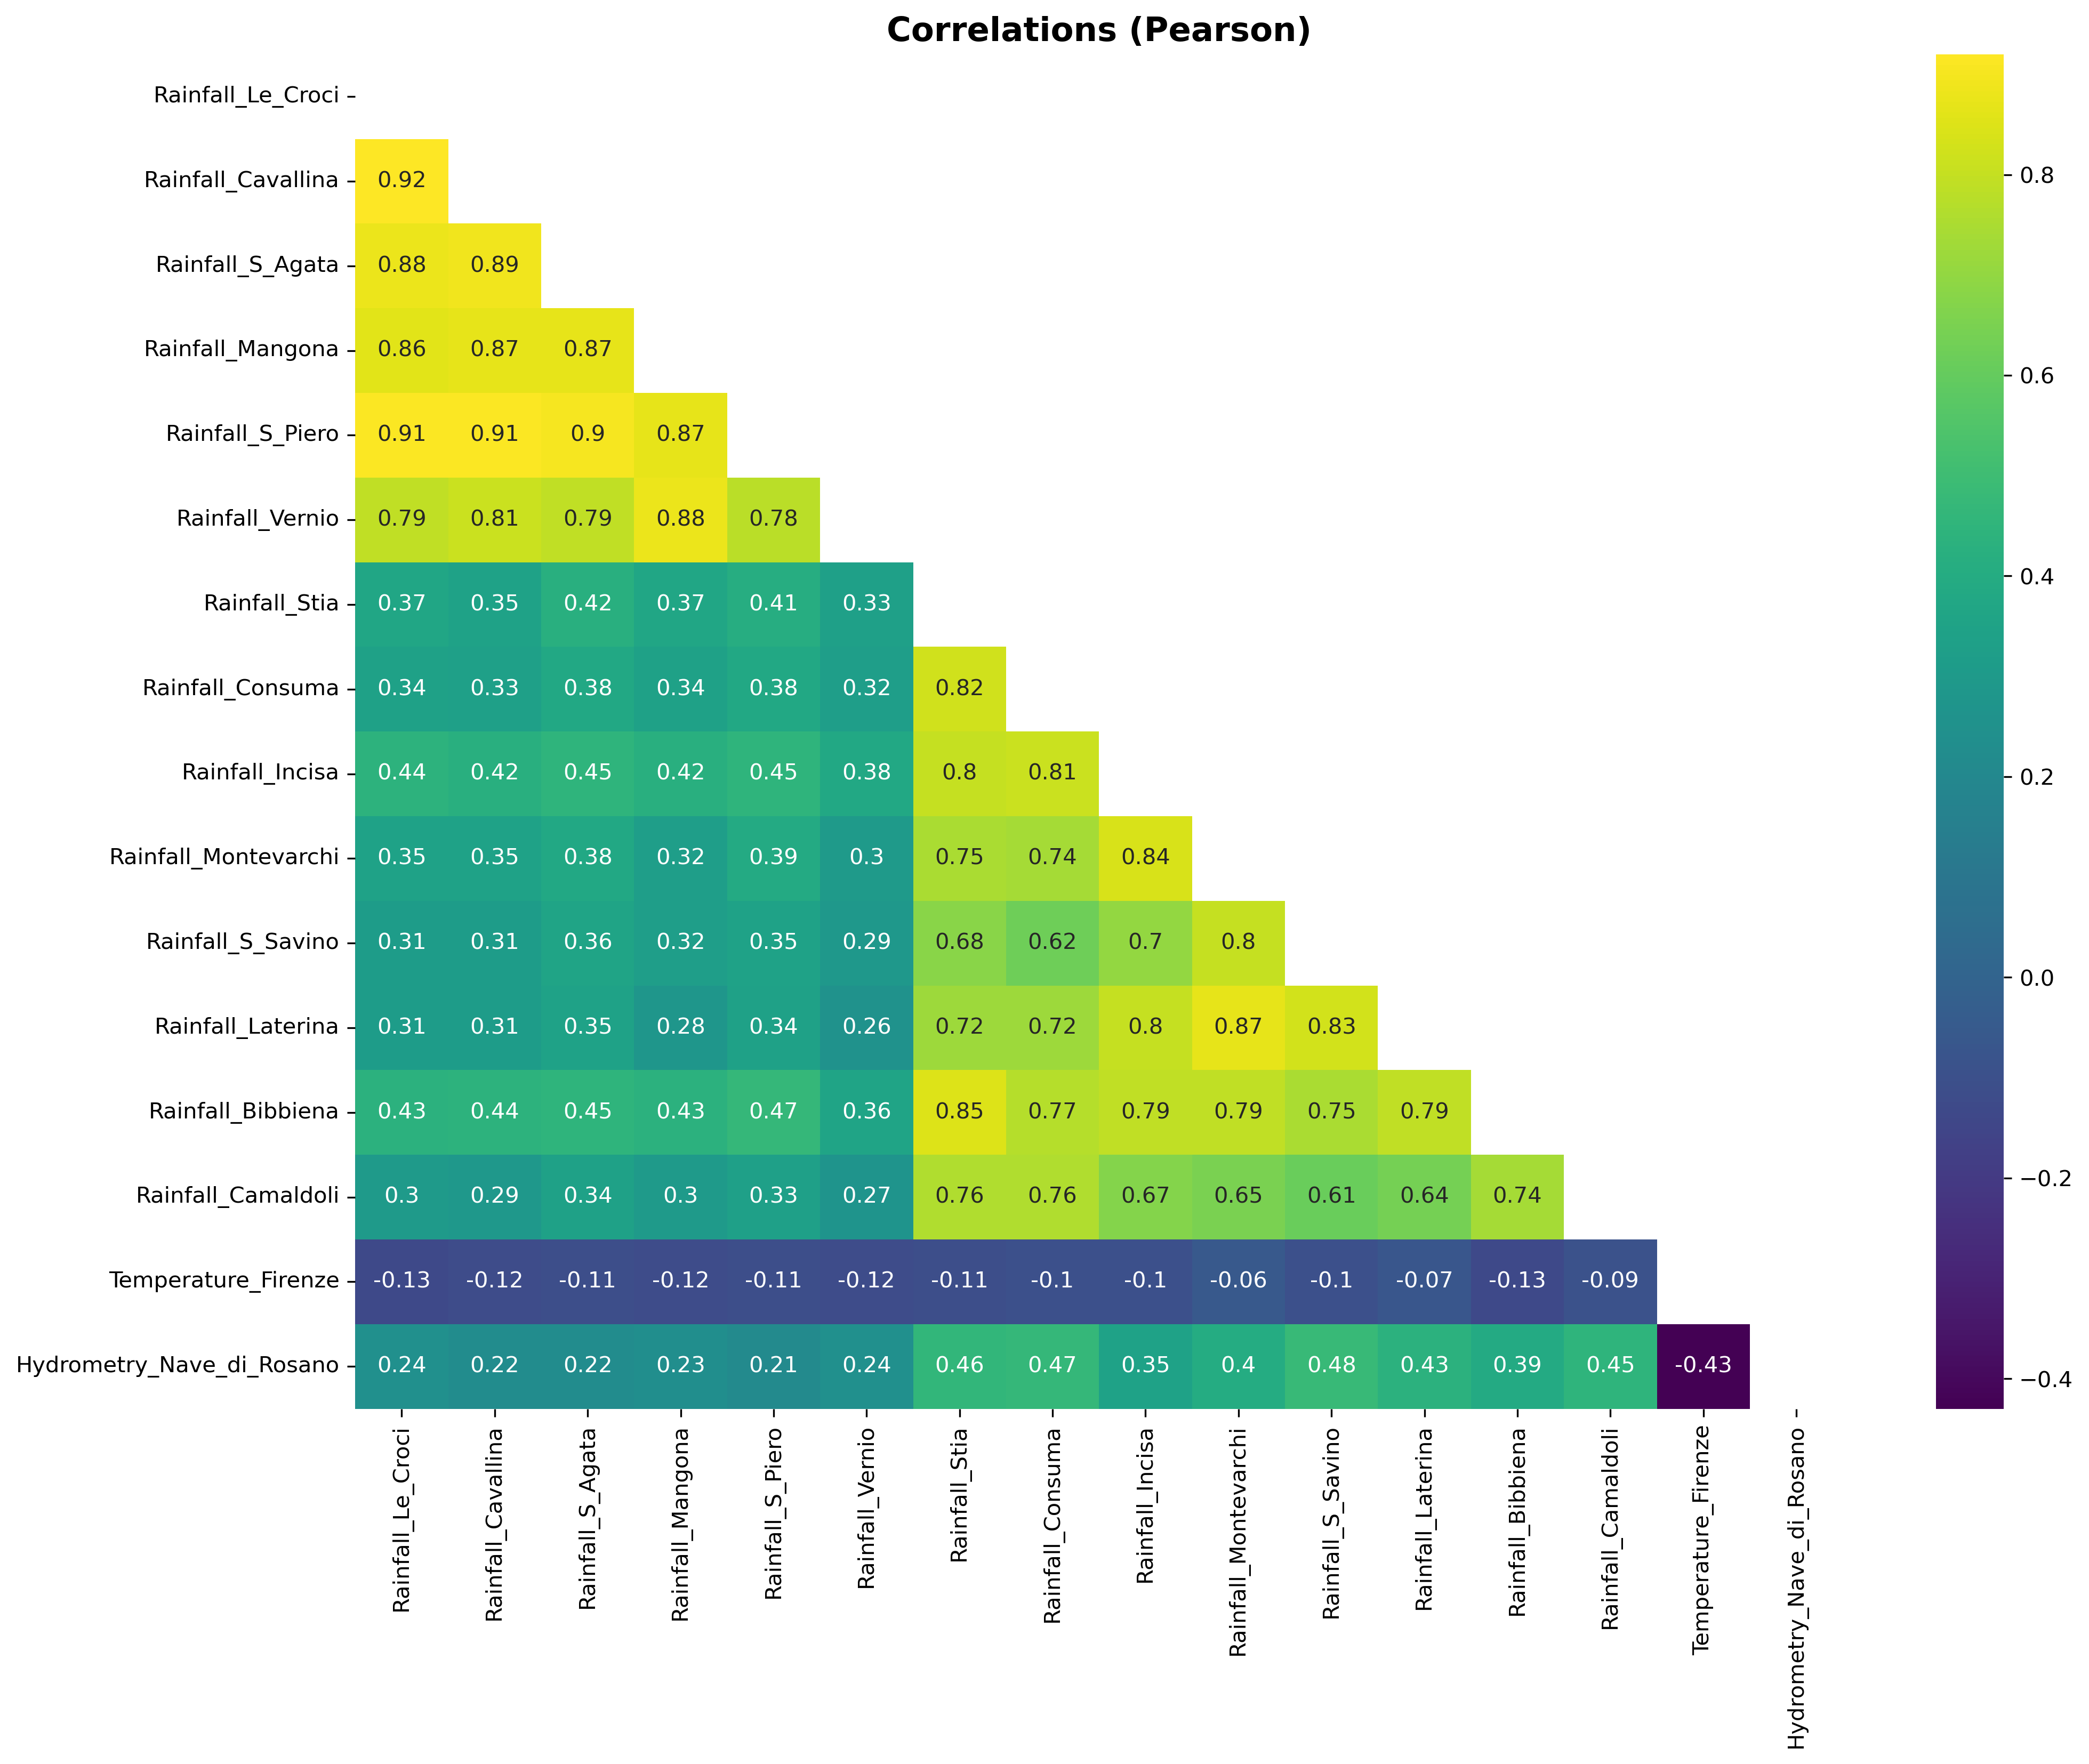

In [10]:
corr_plot(datasets[5])

In [11]:
#Adding rainfall Sum, year, month, month_year
df = rv_arno[['Hydrometry_Nave_di_Rosano', 'Temperature_Firenze']].reset_index()
df['rainfall'] = rv_arno.iloc[:, 0:-2].sum(axis = 1).values
df['year'] = pd.to_datetime(df.Date).dt.year
df['month'] = pd.to_datetime(df.Date).dt.month
df['month_year'] = pd.to_datetime(df.Date).apply(lambda x: x.strftime('%Y/%m'))


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



C:\Users\Safeer\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


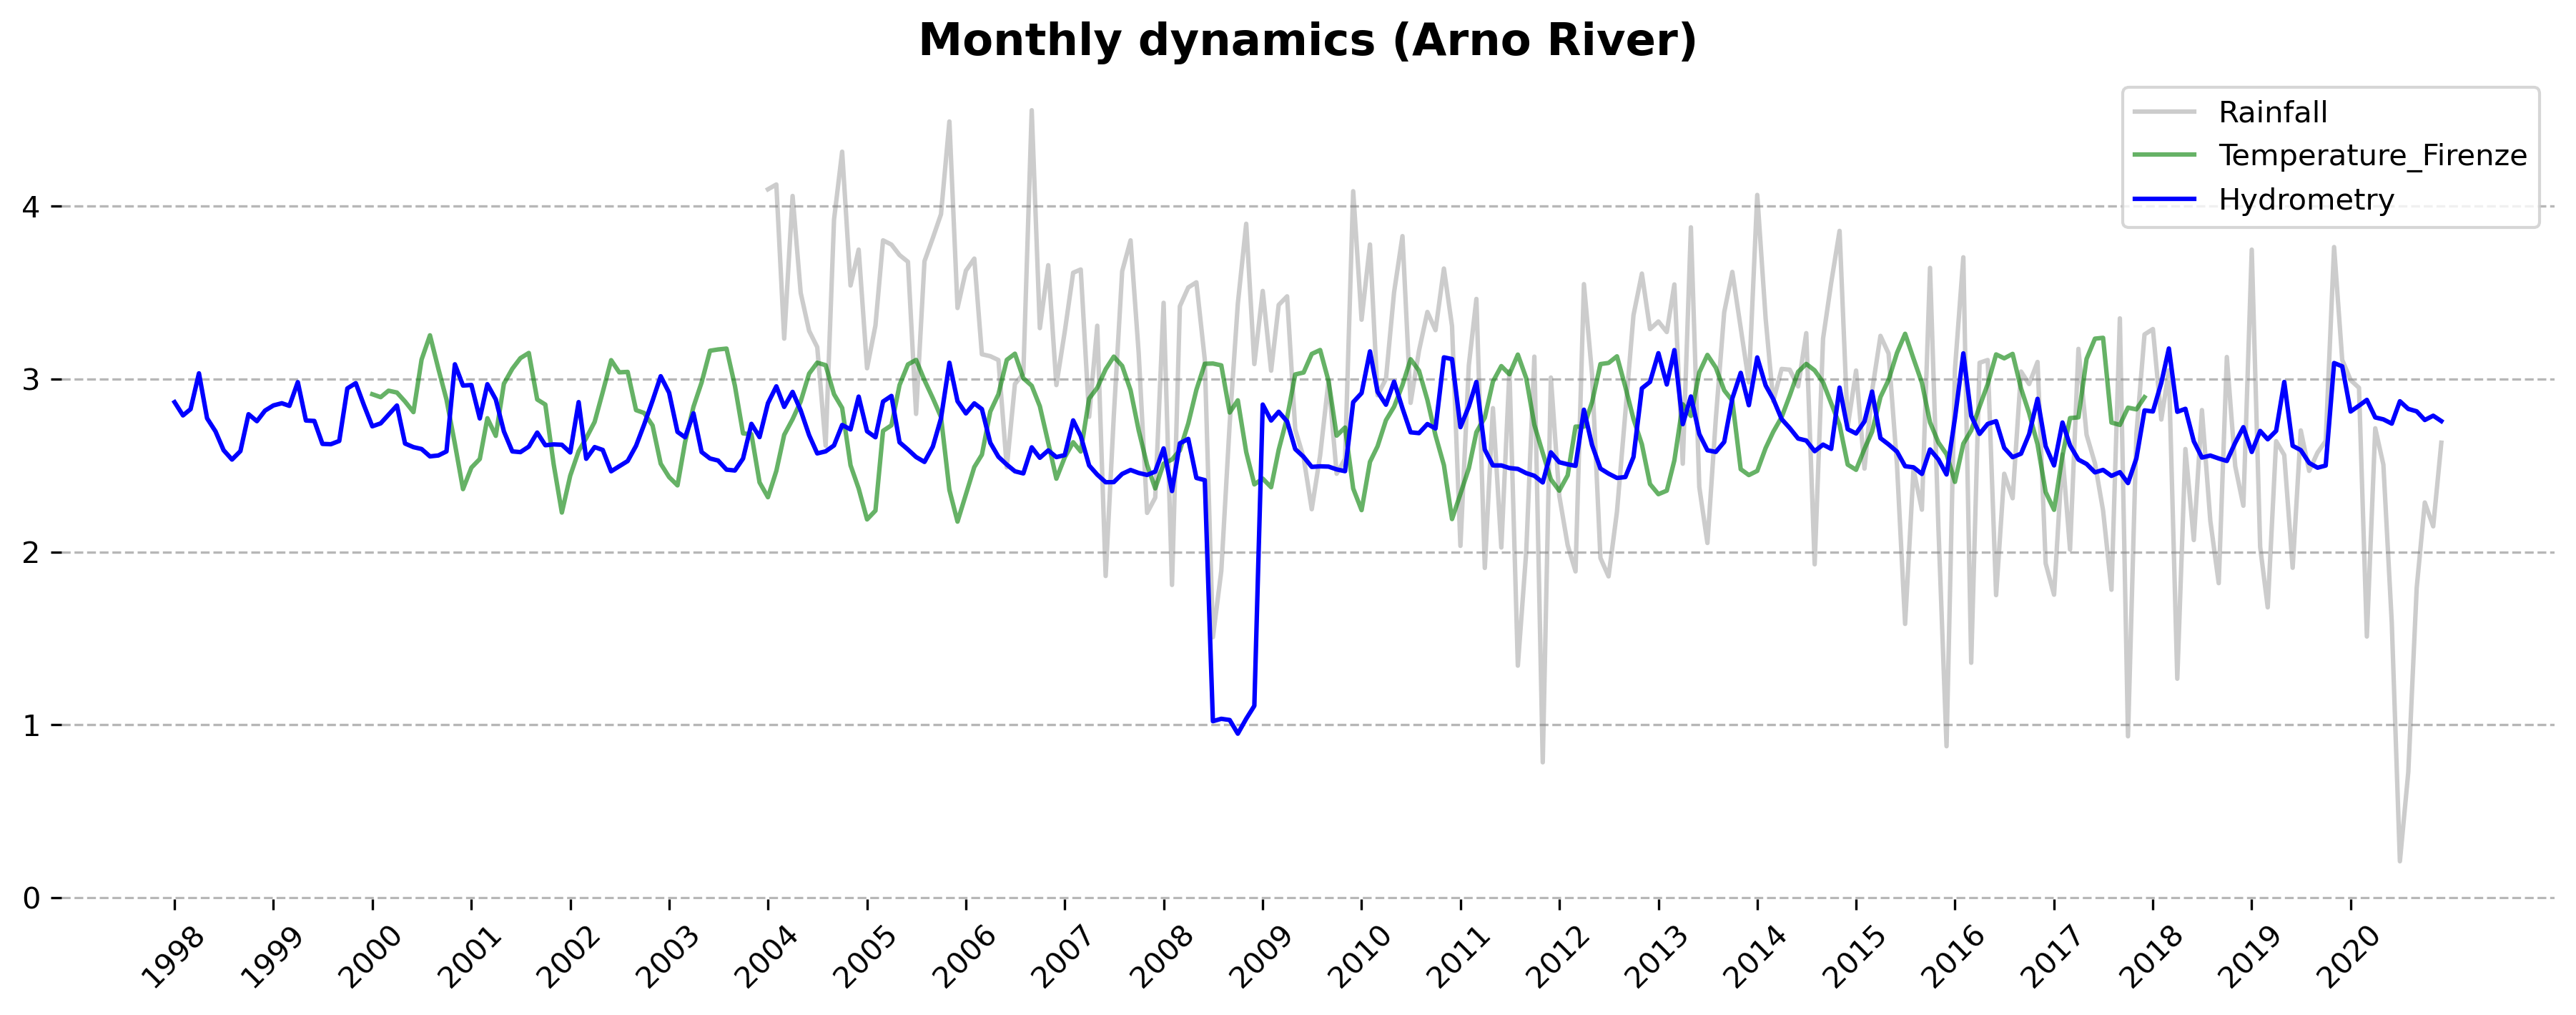

In [12]:
# Monthly dynamics
r_means = np.log(df.groupby('month_year').Hydrometry_Nave_di_Rosano.mean() * 10).reset_index()
r_means['month_year'] = pd.to_datetime(r_means['month_year'])

r_rain = np.log(df.groupby('month_year').rainfall.mean()).reset_index()
r_rain['month_year'] = pd.to_datetime(r_rain['month_year'])

r_temp = np.log(df.groupby('month_year').Temperature_Firenze.mean()).reset_index()
r_temp['month_year'] = pd.to_datetime(r_temp['month_year'])

fig, ax = plt.subplots(figsize = (15, 5))
plt.title('Monthly dynamics (Arno River)', size = 15, fontweight = 'bold')
          
sns.lineplot(data = r_rain, x = 'month_year', y = 'rainfall',  
             color = 'gray', label = 'Rainfall', alpha = 0.4)
plt.xticks(rotation = 45)
sns.lineplot(data = r_temp, x = 'month_year', y = 'Temperature_Firenze', 
             color = 'green', label = 'Temperature_Firenze', alpha = 0.6)
plt.xticks(rotation = 45)
sns.lineplot(data = r_means, x = 'month_year', y = 'Hydrometry_Nave_di_Rosano', 
             color = 'blue', label = 'Hydrometry')
plt.xticks(rotation = 45)
    
for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_visible(False)

ax.set_xticks(r_means.month_year[::12])
ax.set_xticklabels(range(1998, 2021, 1))
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid(axis = 'y', linestyle = '--', alpha = 0.9)
plt.show();


C:\Users\Safeer\AppData\Local\Temp\ipykernel_15472\4262659562.py:51: UserWarning: Parsing '13/01/1998' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])
C:\Users\Safeer\AppData\Local\Temp\ipykernel_15472\4262659562.py:51: UserWarning: Parsing '14/01/1998' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])
C:\Users\Safeer\AppData\Local\Temp\ipykernel_15472\4262659562.py:51: UserWarning: Parsing '15/01/1998' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])
C:\Users\Safeer\AppData\Local\Temp\ipykernel_15472\4262659562.py:51: UserWarning: Parsing '16/01/1998' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])
C:\Users\Safeer\AppData\

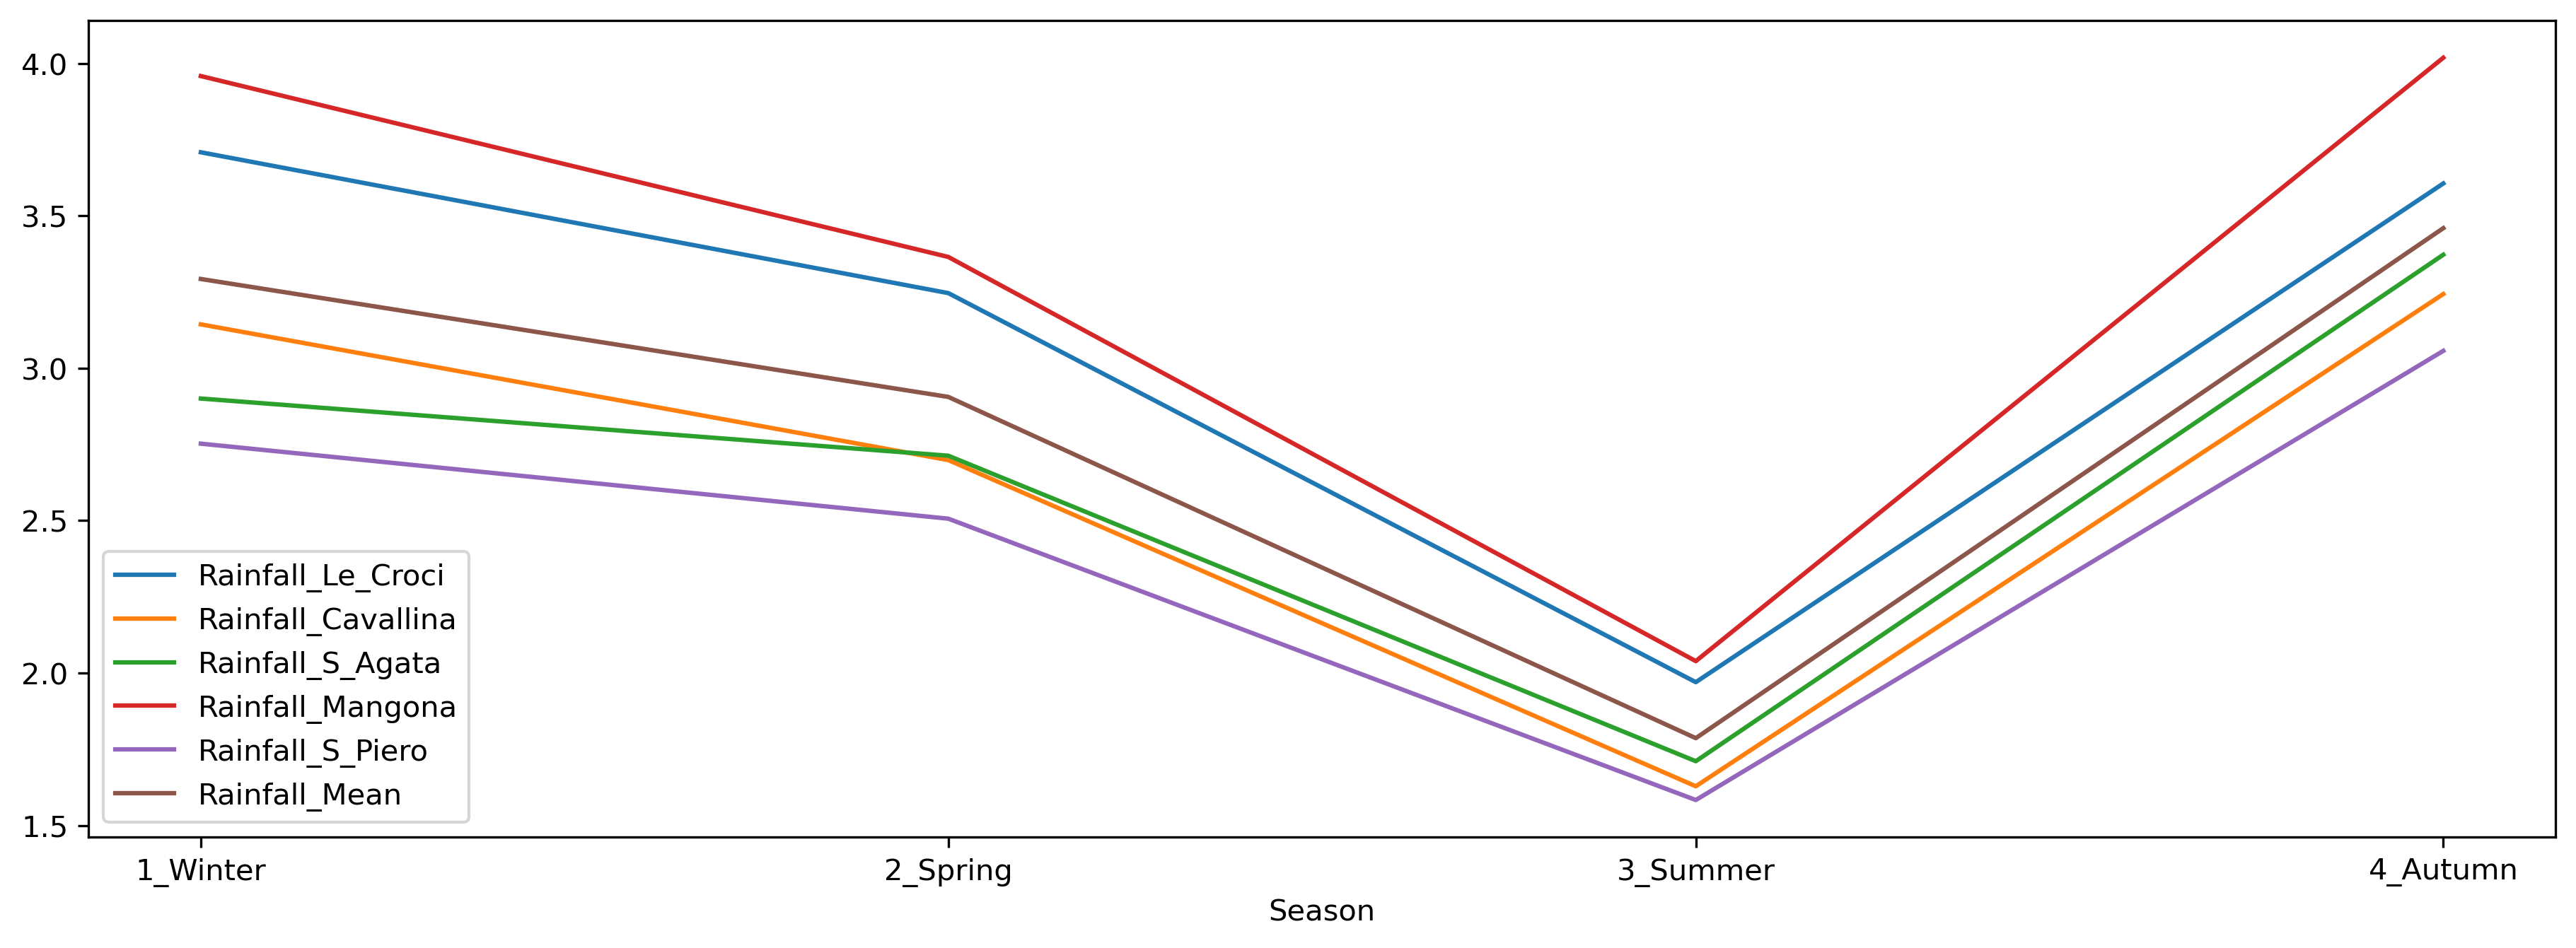

In [13]:
rv_arno_wrk = do_dates(rv_arno).drop(columns=['Rainfall_Vernio','Rainfall_Stia','Rainfall_Consuma', \
    'Rainfall_Incisa', 'Rainfall_Montevarchi', 'Rainfall_S_Savino', 'Rainfall_Laterina', 'Rainfall_Bibbiena', 'Rainfall_Camaldoli'])
rv_arno_wrk['Rainfall_Mean'] = rv_arno_wrk.iloc[:, 1:6].mean(axis = 1).values
rv_arno_wrk
test = rv_arno_wrk.groupby('Season').mean().drop(columns=['Year','Month','Temperature_Firenze','Hydrometry_Nave_di_Rosano'])

fig, ax = plt.subplots(figsize = (15, 5))
sns.lineplot(data=test, dashes=False);

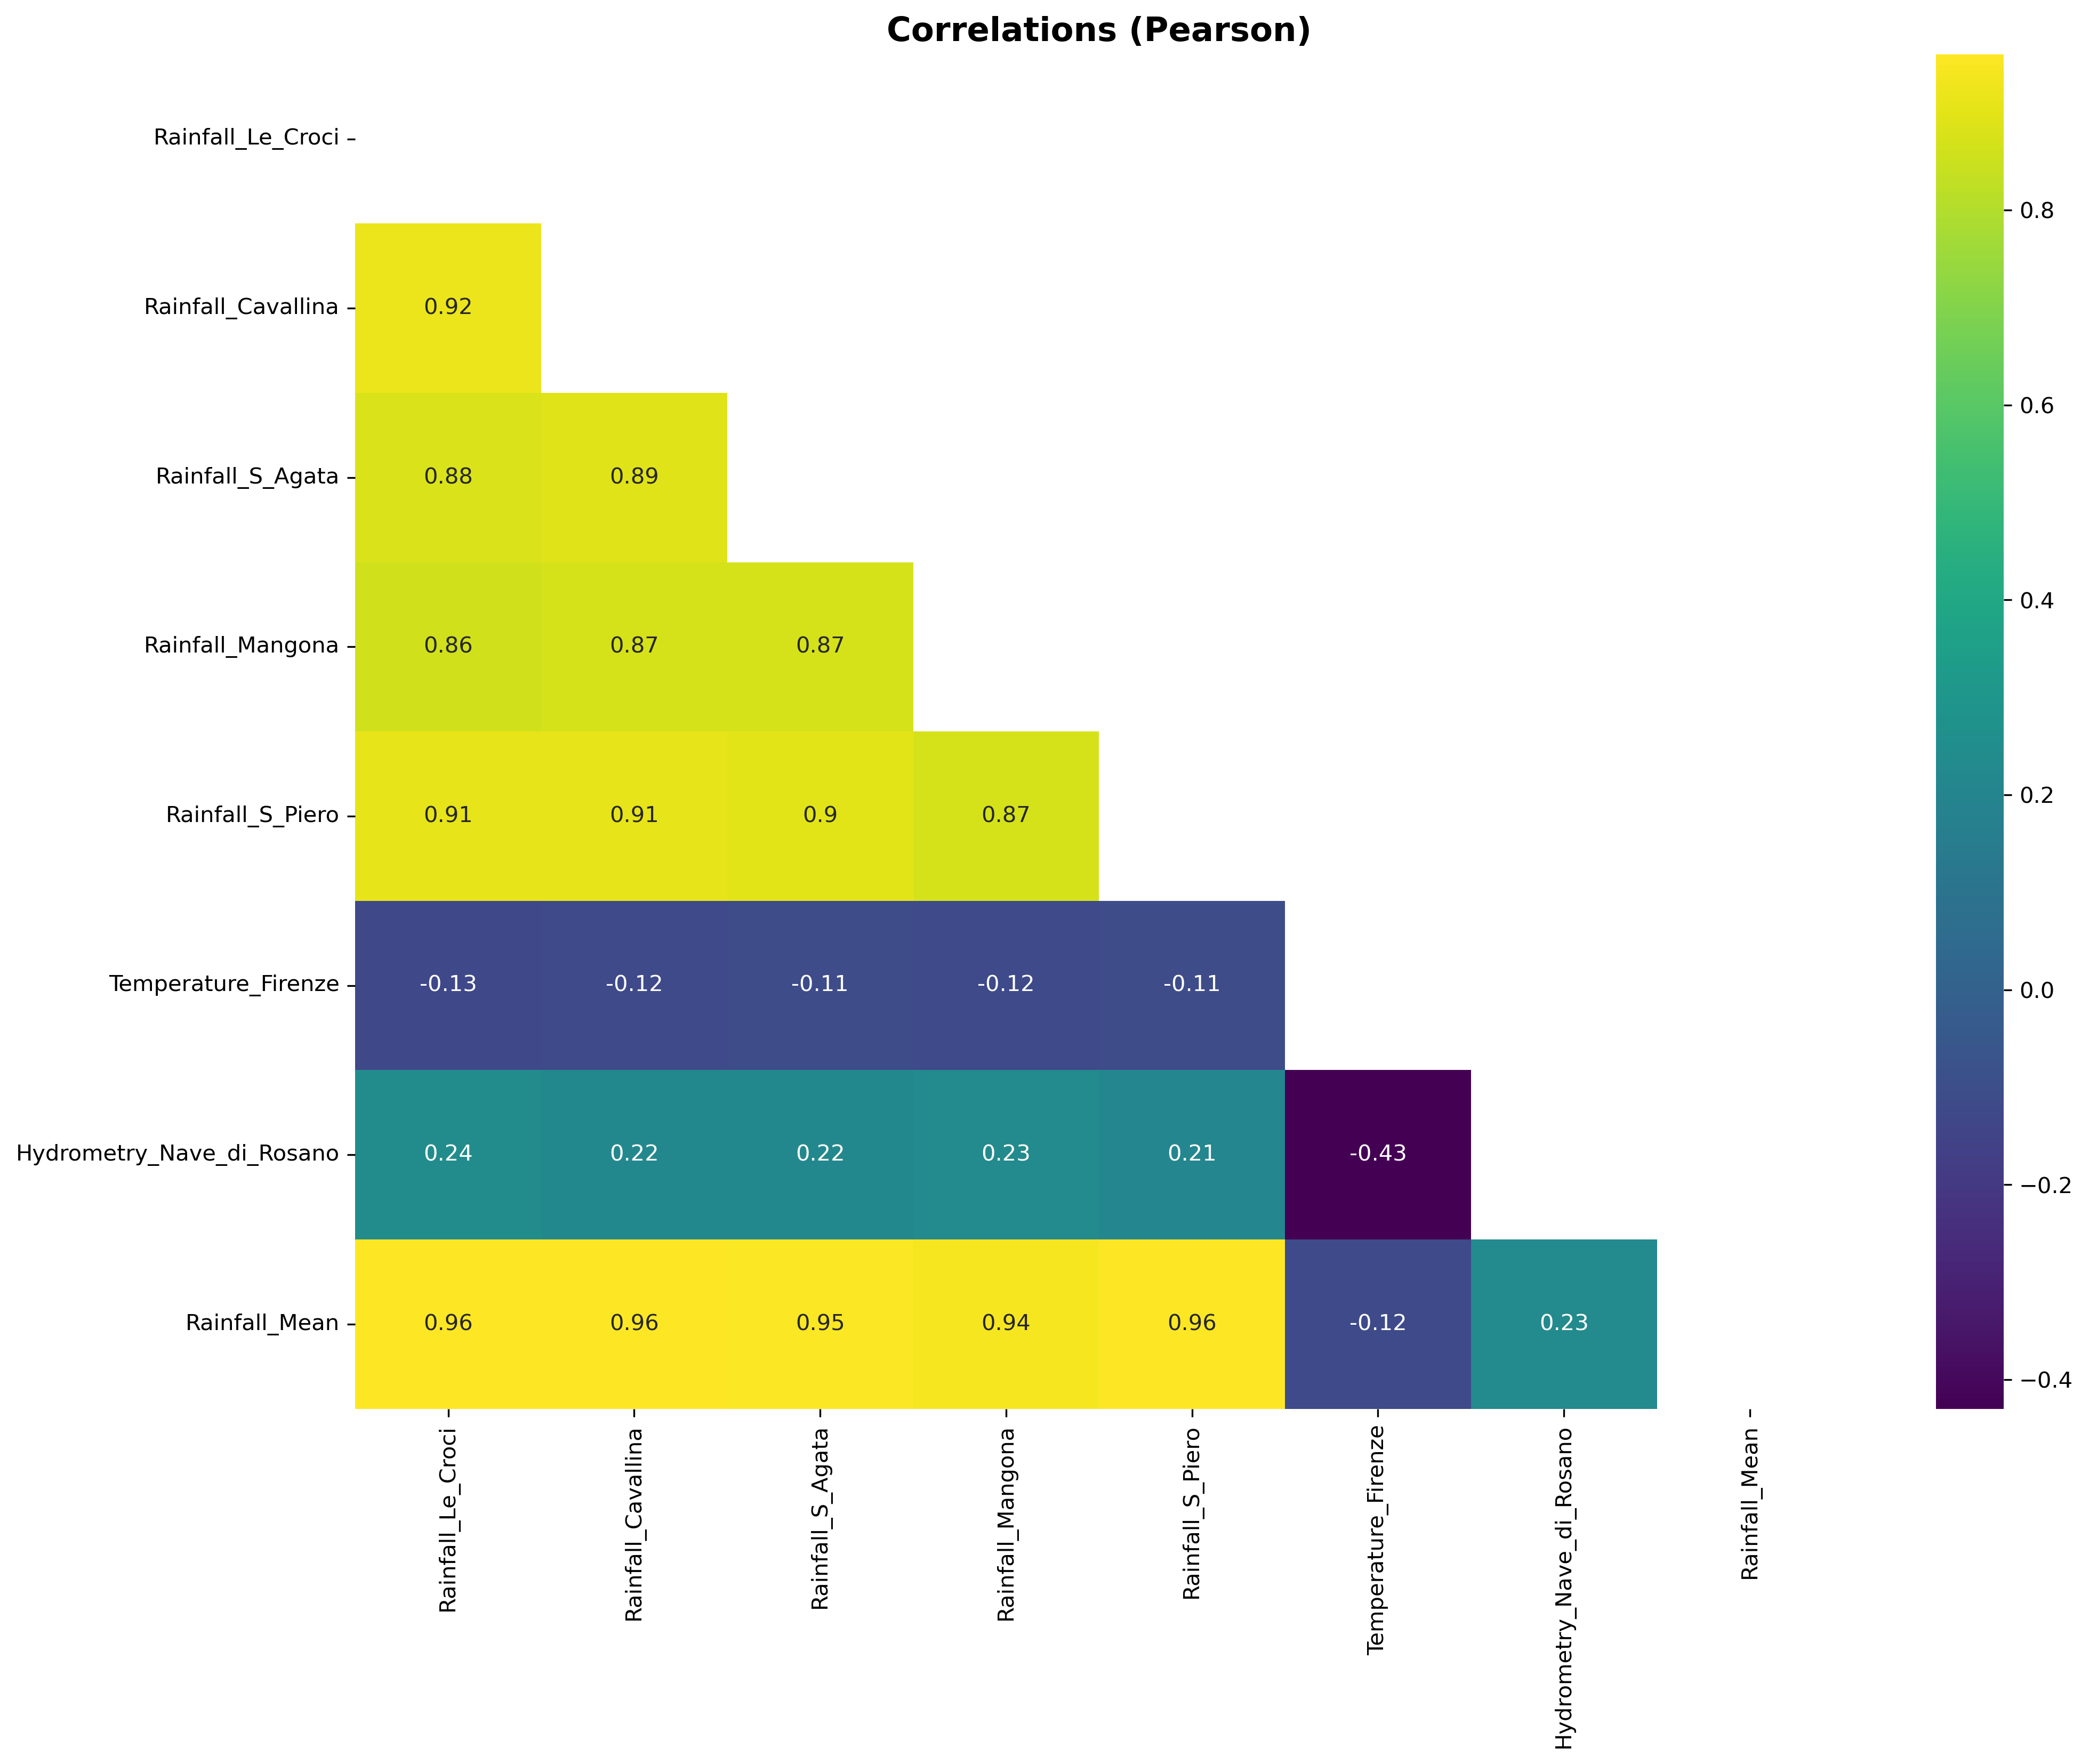

C:\Users\Safeer\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBoostError: [15:28:28] ..\src\data\data.cc:367: Check failed: valid: Label contains NaN, infinity or a value too large.

In [14]:
rv_arno_wrk_model = rv_arno_wrk.set_index('Date')
corr_plot(rv_arno_wrk_model.drop(columns=['Year','Month']))
y = rv_arno_wrk_model['Hydrometry_Nave_di_Rosano']
X = rv_arno_wrk_model.drop(['Hydrometry_Nave_di_Rosano','Season','Month','Year'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle = False)

params = {'n_estimators': 100,
          'max_depth': 4,
          'subsample': 0.7,
          'learning_rate': 0.04,
          'random_state': 0}

model = XGBRegressor(**params)

model.fit(X_train, y_train,)

y_pred = model.predict(X_test)
print('MAE value: %.4f'%mean_absolute_error(y_test, y_pred))

In [21]:
rv_arno_wrk_model

Rainfall_Le_Croci  Rainfall_Cavallina  Rainfall_S_Agata  \
Date                                                                  
1998-01-01                NaN                 NaN               NaN   
1998-01-02                NaN                 NaN               NaN   
1998-01-03                NaN                 NaN               NaN   
1998-01-04                NaN                 NaN               NaN   
1998-01-05                NaN                 NaN               NaN   
...                       ...                 ...               ...   
2020-12-02                1.0                 1.4               3.0   
2020-12-03                0.0                 0.0               0.2   
2020-12-04                0.2                 0.2               0.0   
2020-12-05                0.0                 0.0               0.0   
2020-12-06               19.8                15.0               8.0   

            Rainfall_Mangona  Rainfall_S_Piero  Temperature_Firenze  \
Date                                                                  
1998-01-01               NaN               NaN                  NaN   
1998-01-02               NaN               NaN                  NaN   
1998-01-03               NaN               NaN                  NaN   
1998-01-04               NaN               NaN                  NaN   
1998-01-05               NaN               NaN                  NaN   
...                      ...               ...                  ...   
2020-12-02               7.6               1.4                  NaN   
2020-12-03               1.0               0.2                  NaN   
2020-12-04               0.0               0.0                  NaN   
2020-12-05               0.0               0.2                  NaN   
2020-12-06               8.0              16.0                  NaN   

            Hydrometry_Nave_di_Rosano  Month  Year    Season  Rainfall_Mean  
Date                                                                         
1998-01-01                       1.82      1  1998  1_Winter            NaN  
1998-01-02                       1.45      1  1998  1_Winter            NaN  
1998-01-03                       1.45      1  1998  1_Winter            NaN  
1998-01-04                       1.70      1  1998  1_Winter            NaN  
1998-01-05                       2.37      1  1998  1_Winter            NaN  
...                               ...    ...   ...       ...            ...  
2020-12-02                       1.65     12  2020  1_Winter           2.88  
2020-12-03                       1.94     12  2020  1_Winter           0.28  
2020-12-04                       1.35     12  2020  1_Winter           0.08  
2020-12-05                       1.47     12  2020  1_Winter           0.04  
2020-12-06                       1.46     12  2020  1_Winter          13.36  

[8217 rows x 11 columns]

In [23]:
rv_arno_wrk_model.columns

Index(['Rainfall_Le_Croci', 'Rainfall_Cavallina', 'Rainfall_S_Agata',
       'Rainfall_Mangona', 'Rainfall_S_Piero', 'Temperature_Firenze',
       'Hydrometry_Nave_di_Rosano', 'Month', 'Year', 'Season',
       'Rainfall_Mean'],
      dtype='object')

In [25]:
df_pred = rv_arno_wrk_model.drop('Month',axis=1).drop('Year',axis=1)
df_pred

Rainfall_Le_Croci  Rainfall_Cavallina  Rainfall_S_Agata  \
Date                                                                  
1998-01-01                NaN                 NaN               NaN   
1998-01-02                NaN                 NaN               NaN   
1998-01-03                NaN                 NaN               NaN   
1998-01-04                NaN                 NaN               NaN   
1998-01-05                NaN                 NaN               NaN   
...                       ...                 ...               ...   
2020-12-02                1.0                 1.4               3.0   
2020-12-03                0.0                 0.0               0.2   
2020-12-04                0.2                 0.2               0.0   
2020-12-05                0.0                 0.0               0.0   
2020-12-06               19.8                15.0               8.0   

            Rainfall_Mangona  Rainfall_S_Piero  Temperature_Firenze  \
Date                                                                  
1998-01-01               NaN               NaN                  NaN   
1998-01-02               NaN               NaN                  NaN   
1998-01-03               NaN               NaN                  NaN   
1998-01-04               NaN               NaN                  NaN   
1998-01-05               NaN               NaN                  NaN   
...                      ...               ...                  ...   
2020-12-02               7.6               1.4                  NaN   
2020-12-03               1.0               0.2                  NaN   
2020-12-04               0.0               0.0                  NaN   
2020-12-05               0.0               0.2                  NaN   
2020-12-06               8.0              16.0                  NaN   

            Hydrometry_Nave_di_Rosano    Season  Rainfall_Mean  
Date                                                            
1998-01-01                       1.82  1_Winter            NaN  
1998-01-02                       1.45  1_Winter            NaN  
1998-01-03                       1.45  1_Winter            NaN  
1998-01-04                       1.70  1_Winter            NaN  
1998-01-05                       2.37  1_Winter            NaN  
...                               ...       ...            ...  
2020-12-02                       1.65  1_Winter           2.88  
2020-12-03                       1.94  1_Winter           0.28  
2020-12-04                       1.35  1_Winter           0.08  
2020-12-05                       1.47  1_Winter           0.04  
2020-12-06                       1.46  1_Winter          13.36  

[8217 rows x 9 columns]

In [18]:
def predicted_viz(y_test, y_pred, param, name):
    rm = y_test.reset_index()
    rm['month_year'] = pd.to_datetime(rm.Date).apply(lambda x: x.strftime('%Y/%m'))
    rm_means = rm.groupby('month_year')[param].mean().reset_index()
    rm_means['month_year'] = pd.to_datetime(rm_means['month_year'])

    pm = pd.DataFrame({'Date': y_test.index, param: y_pred})
    pm['month_year'] = pd.to_datetime(pm.Date).apply(lambda x: x.strftime('%Y/%m'))
    pm_means = pm.groupby('month_year')[param].mean().reset_index()
    pm_means['month_year'] = pd.to_datetime(pm_means['month_year'])

    fig, ax = plt.subplots(figsize = (15, 5))
    plt.title('{} prediction ({})'.format(param, name), size = 15, 
              fontweight = 'bold')

    sns.lineplot(data = rm_means, x = 'month_year', y = param, 
                 color = 'blue', label = 'Real {}'.format(param), alpha = 1)
    sns.lineplot(data = pm_means, x = 'month_year', y = param, 
                 color = 'red', label = 'Pred {}'.format(param), alpha = 0.5)

    for i in ['top', 'right', 'bottom', 'left']:
            ax.spines[i].set_visible(False)

    ax.set_xticks(rm_means.month_year[::12])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(axis = 'y', linestyle = '--', alpha = 0.9)
    plt.show()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df_pred, df_pred['Hydrometry_Nave_di_Rosano'])

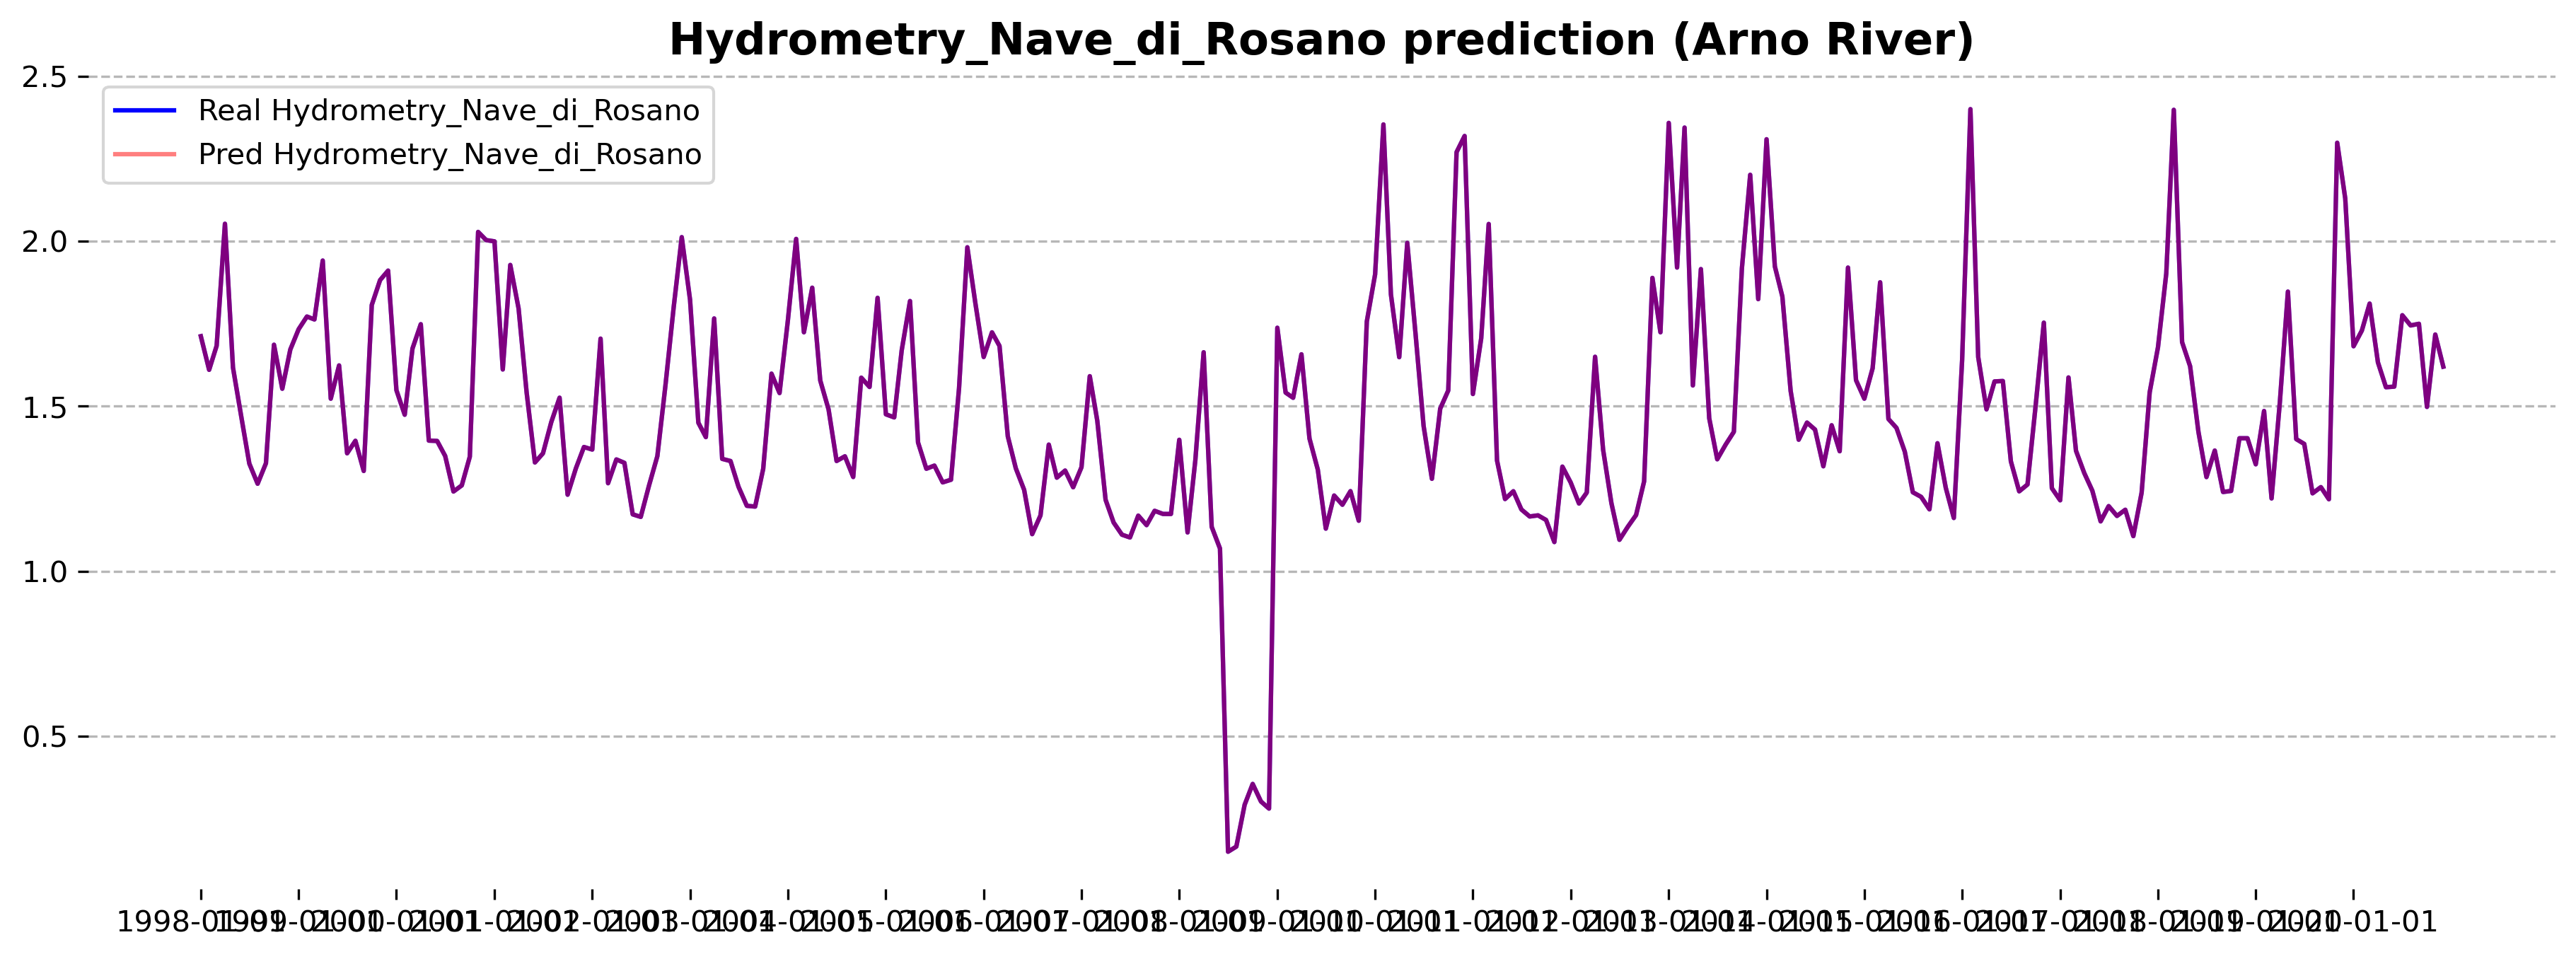

In [32]:
predicted_viz(X_train, y_train, 'Hydrometry_Nave_di_Rosano', 'Arno River')

In [35]:
rv_arno_wrk_model

Rainfall_Le_Croci  Rainfall_Cavallina  Rainfall_S_Agata  \
Date                                                                  
1998-01-01                NaN                 NaN               NaN   
1998-01-02                NaN                 NaN               NaN   
1998-01-03                NaN                 NaN               NaN   
1998-01-04                NaN                 NaN               NaN   
1998-01-05                NaN                 NaN               NaN   
...                       ...                 ...               ...   
2020-12-02                1.0                 1.4               3.0   
2020-12-03                0.0                 0.0               0.2   
2020-12-04                0.2                 0.2               0.0   
2020-12-05                0.0                 0.0               0.0   
2020-12-06               19.8                15.0               8.0   

            Rainfall_Mangona  Rainfall_S_Piero  Temperature_Firenze  \
Date                                                                  
1998-01-01               NaN               NaN                  NaN   
1998-01-02               NaN               NaN                  NaN   
1998-01-03               NaN               NaN                  NaN   
1998-01-04               NaN               NaN                  NaN   
1998-01-05               NaN               NaN                  NaN   
...                      ...               ...                  ...   
2020-12-02               7.6               1.4                  NaN   
2020-12-03               1.0               0.2                  NaN   
2020-12-04               0.0               0.0                  NaN   
2020-12-05               0.0               0.2                  NaN   
2020-12-06               8.0              16.0                  NaN   

            Hydrometry_Nave_di_Rosano  Month  Year    Season  Rainfall_Mean  
Date                                                                         
1998-01-01                       1.82      1  1998  1_Winter            NaN  
1998-01-02                       1.45      1  1998  1_Winter            NaN  
1998-01-03                       1.45      1  1998  1_Winter            NaN  
1998-01-04                       1.70      1  1998  1_Winter            NaN  
1998-01-05                       2.37      1  1998  1_Winter            NaN  
...                               ...    ...   ...       ...            ...  
2020-12-02                       1.65     12  2020  1_Winter           2.88  
2020-12-03                       1.94     12  2020  1_Winter           0.28  
2020-12-04                       1.35     12  2020  1_Winter           0.08  
2020-12-05                       1.47     12  2020  1_Winter           0.04  
2020-12-06                       1.46     12  2020  1_Winter          13.36  

[8217 rows x 11 columns]

In [ ]:
df_pred.